<a href="https://colab.research.google.com/github/duvanjcalderonr/proyecto-electiva-IA-de-Crypto/blob/main/Proyecto_LSTM_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Catalina Alejandra Nieto Alcala
*   Andres Camilo Aristizabal
*   Eduar Santiago Prieto Prieto
*   Duvan Jose Calderon Romero

In [ ]:
import numpy as np
np.random.seed(4)
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

dataset = pd.read_csv('/content/drive/MyDrive/Estudio/10mo Semestre/DevOps (Electica 2)/Bitcoin2.csv', delimiter=';',encoding='utf-8-sig')
print("Columnas Originales")
print(dataset.columns.tolist())
print(f"Número de columnas originales: {len(dataset.columns)}")

dataset = dataset.drop(columns='timeClose') # =========================
dataset = dataset.drop(columns='timeHigh')  # Se remueven las columnas
dataset = dataset.drop(columns='timeLow')   # no deseadas en el dataset
dataset = dataset.drop(columns='timestamp') # =========================
columnas_ordenadas = [col for col in dataset.columns if col != 'name']
columnas_ordenadas.append('name')
dataset = dataset[columnas_ordenadas] # Se reorganizan las columnas restantes
dataset['timeOpen'] = pd.to_datetime(dataset['timeOpen']).dt.strftime('%Y-%m-%d') # Se elimina la hora de la fecha
dataset = dataset.sort_values('timeOpen')
dataset = dataset.rename(columns={'timeOpen': 'Date'}) # Se actualiza el nombre de la columna de las fechas
dataset = dataset.set_index('Date')  # Establecemos Date como índice
dataset.index = pd.to_datetime(dataset.index)  # Convertir índice a datetime
dataset.info()
print("Columnas Eliminadas")
print(dataset.columns.tolist())
dataset.head() # Mostramos el resultado del dataset una vez limpio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columnas Originales
['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']
Número de columnas originales: 12
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5589 entries, 2010-07-14 to 2025-10-31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       5589 non-null   float64
 1   high       5589 non-null   float64
 2   low        5589 non-null   float64
 3   close      5589 non-null   float64
 4   volume     5589 non-null   float64
 5   marketCap  5589 non-null   float64
 6   name       5589 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 349.3 KB
Columnas Eliminadas
['open', 'high', 'low', 'close', 'volume', 'marketCap', 'name']


,open,high,low,close,volume,marketCap,name
Date,,,,,,,
2010-07-14,0.058157,0.061588,0.048647,0.056402,261.54,190259.65,2781
2010-07-15,0.056403,0.067954,0.053969,0.057568,445.80,195982.14,2781
2010-07-16,0.058001,0.072220,0.057484,0.066492,497.25,228047.42,2781
2010-07-17,0.066500,0.077735,0.057418,0.065993,19.99,226904.80,2781
2010-07-18,0.066088,0.080858,0.064221,0.078814,75.13,271669.20,2781


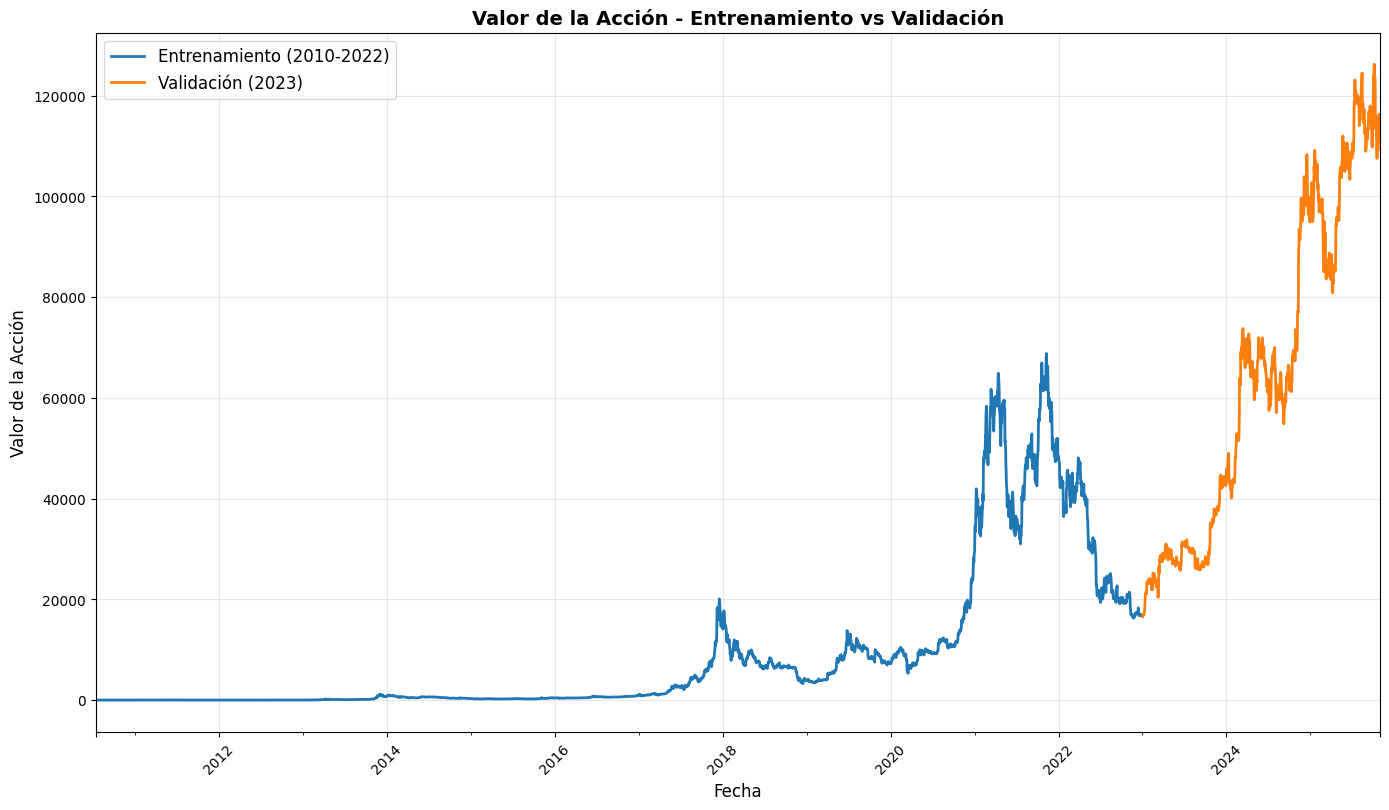

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Configurar el tamaño de la figura ANTES de crear el gráfico
plt.figure(figsize=(14, 8))  # Hacer la figura más ancha y alta

# Ordenar el dataset si es necesario
dataset = dataset.sort_index()

# Definir los conjuntos de datos
set_entrenamiento = dataset[:'2022'].iloc[:, 1:2]  # Hasta 2022
set_validacion = dataset['2023':].iloc[:, 1:2]     # Desde 2023

# Crear el gráfico
set_entrenamiento['high'].plot(legend=True, linewidth=2)
set_validacion['high'].plot(legend=True, linewidth=2)

# Personalizar el gráfico
plt.title('Valor de la Acción - Entrenamiento vs Validación', fontsize=14, fontweight='bold')
plt.legend(['Entrenamiento (2010-2022)', 'Validación (2023)'], fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor de la Acción', fontsize=12)

# Mejorar el formato de los ejes
plt.grid(True, alpha=0.3)
plt.tight_layout()  # Ajusta automáticamente los márgenes

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

# Función para graficar predicciones (versión mejorada)
def graficar_predicciones(real, prediccion):
    plt.figure(figsize=(12, 6))
    plt.plot(real[0:len(prediccion)], color='red', label='Valor real de la acción', linewidth=2)
    plt.plot(prediccion, color='blue', label='Predicción de la acción', linewidth=2)

    # Mejorar los límites del eje Y
    y_min = min(np.min(real[0:len(prediccion)]), np.min(prediccion))
    y_max = max(np.max(real[0:len(prediccion)]), np.max(prediccion))
    margen = (y_max - y_min) * 0.1  # 10% de margen

    plt.ylim(y_min - margen, y_max + margen)

    # Personalizar
    plt.xlabel('Tiempo', fontsize=12)
    plt.ylabel('Valor de la acción', fontsize=12)
    plt.title('Comparación: Valores Reales vs Predicciones', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# Función para evaluar métricas y crear tabla
def evaluar_modelo_lstm(y_real, y_pred):
    """
    Evalúa el modelo LSTM usando 4 métricas principales y determina cuál es la más óptima
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import numpy as np

    # Calcular las 4 métricas
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)

    # Crear tabla de resultados
    print("=" * 60)
    print("📊 EVALUACIÓN DEL MODELO LSTM - BITCOIN")
    print("=" * 60)
    print(f"{'Métrica':<10} {'Valor':<15} {'Objetivo':<15} {'Interpretación'}")
    print("-" * 60)
    print(f"{'MSE':<10} {mse:<15.6f} {'Minimizar':<15} Error Cuadrático Medio")
    print(f"{'RMSE':<10} {rmse:<15.6f} {'Minimizar':<15} Raíz del Error Cuadrático")
    print(f"{'MAE':<10} {mae:<15.6f} {'Minimizar':<15} Error Absoluto Medio")
    print(f"{'R²':<10} {r2:<15.6f} {'Maximizar':<15} Coeficiente de Determinación")
    print("=" * 60)

    # Determinar la métrica más óptima
    # Para MSE, RMSE, MAE: valores más bajos son mejores
    # Para R²: valores más altos son mejores (más cercanos a 1)

    # Normalizar las métricas para comparación
    scores_normalizados = {
        'MSE': 1 / (1 + mse) if mse != 0 else 1,  # Transformar a escala 0-1
        'RMSE': 1 / (1 + rmse) if rmse != 0 else 1,
        'MAE': 1 / (1 + mae) if mae != 0 else 1,
        'R²': r2  # Ya está en escala 0-1 (idealmente)
    }

    # Encontrar la métrica más óptima
    metrica_optima = max(scores_normalizados, key=scores_normalizados.get)

    print(f"\n🔍 ANÁLISIS DE RESULTADOS:")
    print(f"   • MSE:  {mse:12.6f} (Penaliza errores grandes)")
    print(f"   • RMSE: {rmse:12.6f} (En unidades originales)")
    print(f"   • MAE:  {mae:12.6f} (Error promedio absoluto)")
    print(f"   • R²:   {r2:12.6f} (Varianza explicada: {r2*100:.2f}%)")

    print(f"\n🏆 MÉTRICA MÁS ÓPTIMA: {metrica_optima}")

    # Interpretación específica
    if metrica_optima == 'R²':
        if r2 > 0.8:
            print("   ✅ EXCELENTE - El modelo explica más del 80% de la varianza")
        elif r2 > 0.6:
            print("   ✅ BUENO - El modelo explica más del 60% de la varianza")
        else:
            print("   ⚠️  MODERADO - Capacidad explicativa limitada")
    else:
        print(f"   ✅ MENOR ERROR - {metrica_optima} tiene el mejor desempeño en precisión")

    # Interpretación general del R²
    print(f"\n📈 INTERPRETACIÓN R²:")
    if r2 > 0.9:
        print("   🎯 Excelente ajuste del modelo")
    elif r2 > 0.7:
        print("   ✅ Buen ajuste del modelo")
    elif r2 > 0.5:
        print("   ⚠️  Ajuste moderado del modelo")
    else:
        print("   ❌ Bajo poder predictivo")

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}, metrica_optima

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler (feature_range = (0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [ ]:
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 100
modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense (units=dim_salida))
modelo.compile(optimizer='rmsprop', loss = 'mse', metrics=['mse', 'mae'])
modelo.fit(X_train,Y_train, epochs=30, batch_size=32)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0065 - mae: 0.0338 - mse: 0.0065
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 4.8663e-04 - mae: 0.0121 - mse: 4.8663e-04
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 3.9177e-04 - mae: 0.0109 - mse: 3.9177e-04
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 3.1325e-04 - mae: 0.0099 - mse: 3.1325e-04
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 2.3919e-04 - mae: 0.0089 - mse: 2.3919e-04
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 2.6619e-04 - mae: 0.0086 - mse: 2.6619e-04
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 2.1758e-04 - mae: 0.0087 - mse: 2.1758e-04
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 1.8857e-04 - mae: 0.0080 - mse: 1.8857e-04
Epoch 9/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.9282e-04 - mae: 0.0081 - mse: 1.9282e-04
Epoch 10/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 2.0136e-04 - mae: 0.

In [ ]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step, len(x_test)):
  X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step



EVALUACIÓN FINAL DEL MODELO LSTM PARA PREDICCIÓN DE BITCOIN
📊 EVALUACIÓN DEL MODELO LSTM - BITCOIN
Métrica    Valor           Objetivo        Interpretación
------------------------------------------------------------
MSE        3637000.657278  Minimizar       Error Cuadrático Medio
RMSE       1907.092199     Minimizar       Raíz del Error Cuadrático
MAE        1360.364040     Minimizar       Error Absoluto Medio
R²         0.996352        Maximizar       Coeficiente de Determinación

🔍 ANÁLISIS DE RESULTADOS:
   • MSE:  3637000.657278 (Penaliza errores grandes)
   • RMSE:  1907.092199 (En unidades originales)
   • MAE:   1360.364040 (Error promedio absoluto)
   • R²:       0.996352 (Varianza explicada: 99.64%)

🏆 MÉTRICA MÁS ÓPTIMA: R²
   ✅ EXCELENTE - El modelo explica más del 80% de la varianza

📈 INTERPRETACIÓN R²:
   🎯 Excelente ajuste del modelo


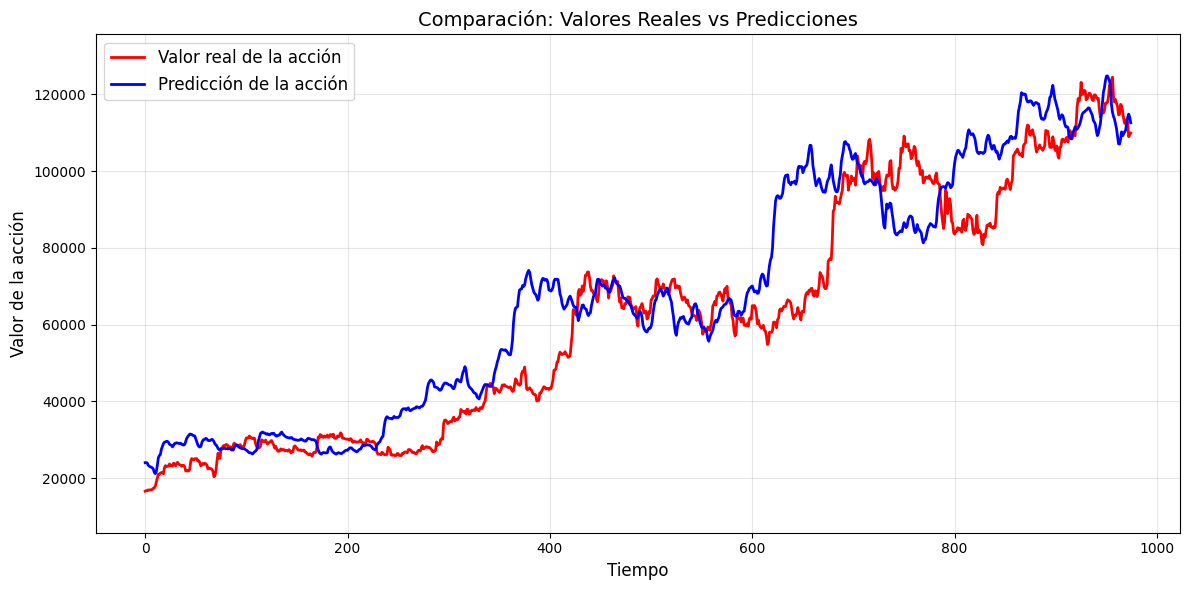


RESUMEN 
Modelo: LSTM con 100 neuronas
Datos de entrenamiento: 4554 registros (hasta 2022)
Datos de validación: 1035 registros (2023 en adelante)
Ventana temporal (time_step): 60 días
Métrica más óptima: R²


In [ ]:
# EVALUAR EL MODELO CON LAS 4 MÉTRICAS
print("\n" + "="*80)
print("EVALUACIÓN FINAL DEL MODELO LSTM PARA PREDICCIÓN DE BITCOIN")
print("="*80)

# Asegurarnos que tenemos las mismas dimensiones para evaluación
y_real = set_validacion.values[time_step:len(prediccion)+time_step]
if len(y_real) > len(prediccion):
    y_real = y_real[:len(prediccion)]

# Llamar a la función de evaluación
metricas, metrica_optima = evaluar_modelo_lstm(y_real, prediccion)

# Graficar resultados
graficar_predicciones(set_validacion.values, prediccion)

# Mostrar resumen final
print("\n" + "="*80)
print("RESUMEN ")
print("="*80)
print(f"Modelo: LSTM con {na} neuronas")
print(f"Datos de entrenamiento: {len(set_entrenamiento)} registros (hasta 2022)")
print(f"Datos de validación: {len(set_validacion)} registros (2023 en adelante)")
print(f"Ventana temporal (time_step): {time_step} días")
print(f"Métrica más óptima: {metrica_optima}")
print("="*80)

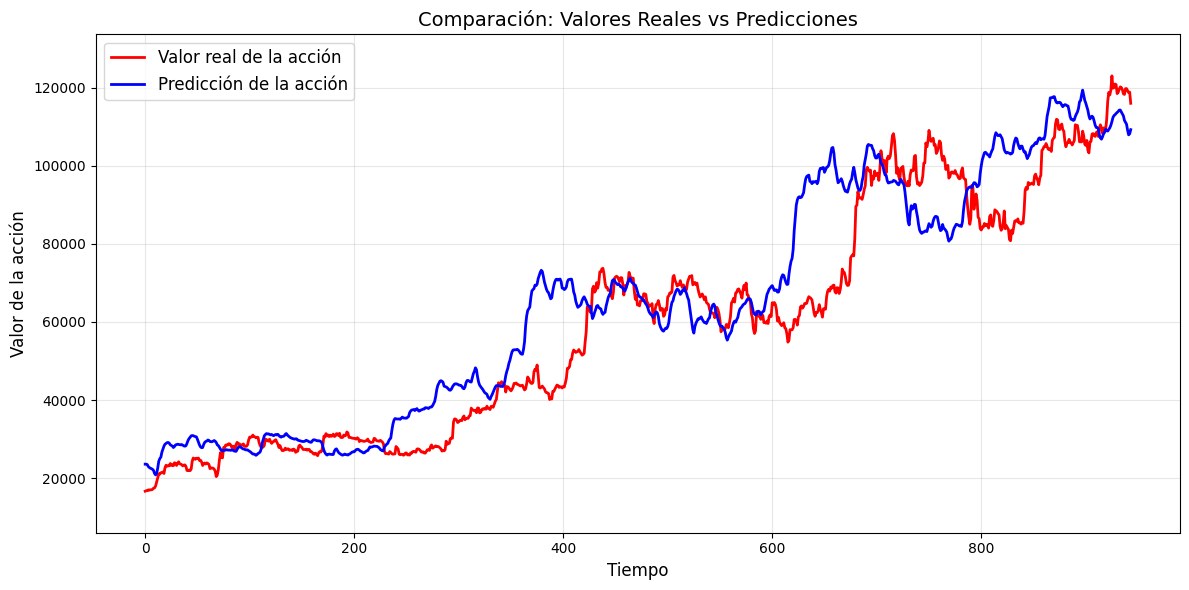

In [ ]:
# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)